In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

raw_data = pd.read_csv('../data/2021-SxS-Data-and-Data-Info/partial_cleaned_2021.csv')
raw_data = raw_data.drop(columns='Unnamed: 0')
raw_data.head()

,state,division,region,gender,age_group,ethnicity,ed_lvl,marital_stat,lvng_arr,marital_stat_v2,...,10k_expense,10k_gift,expect_inheritance,num_cred_cards,health_ins,skipped_med,fin_conf_lvl,math_conf_lvl,knowledge_conf_lvl,fin_ed
0,South Carolina,South Atlantic,South,female,25-34,white,Bachelors,married,2,married,...,1,1,1,2,1,2,7,6,6,2
1,Ohio,East North Central,Midwest,female,25-34,white,Bachelors,divorced,1,single,...,2,2,2,7,1,2,1,1,2,2
2,Arizona,Mountain,West,male,65+,white,Bachelors,divorced,1,single,...,2,2,2,3,1,2,7,7,6,2
3,Arizona,Mountain,West,female,45-54,non-white,HS Grad,married,2,married,...,2,2,2,2,1,2,7,6,5,3
4,Ohio,East North Central,Midwest,female,45-54,white,GED,divorced,1,single,...,2,2,98,7,1,2,6,6,5,3


In [3]:
#Military Only (current or previous)
mil_only_df = raw_data[(raw_data['mil_stat'] == 'current') | (raw_data['mil_stat'] == 'previous')]


In [4]:
combined_df = raw_data[['state','region','math_conf_lvl','fin_sat_lvl','fin_conf_lvl', 'ed_lvl', 'caregiver_ed_lvl', 'hh_ann_inc']]
# Replace all 99 &98 answers with none in columns & drop them since it skews mean
combined_df.loc[combined_df['math_conf_lvl'] == 99, 'math_conf_lvl'] = None
combined_df.loc[combined_df['fin_sat_lvl'] == 99, 'fin_sat_lvl'] = None
combined_df.loc[combined_df['fin_conf_lvl'] == 99, 'fin_conf_lvl'] = None
combined_df.loc[combined_df['math_conf_lvl'] == 98, 'math_conf_lvl'] = None
combined_df.loc[combined_df['fin_sat_lvl'] == 98, 'fin_sat_lvl'] = None
combined_df.loc[combined_df['fin_conf_lvl'] == 98, 'fin_conf_lvl'] = None
combined_df = combined_df.dropna()
combined_df

,state,region,math_conf_lvl,fin_sat_lvl,fin_conf_lvl,ed_lvl,caregiver_ed_lvl,hh_ann_inc
0,South Carolina,South,6.0,9.0,7.0,Bachelors,Associates,200k-300k
1,Ohio,Midwest,1.0,4.0,1.0,Bachelors,Associates,25k-35k
2,Arizona,West,7.0,10.0,7.0,Bachelors,Associates,25k-35k
3,Arizona,West,6.0,9.0,7.0,HS Grad,HS Grad,100k-150k
4,Ohio,Midwest,6.0,4.0,6.0,GED,HS Grad,<= 15k
...,...,...,...,...,...,...,...,...
27113,Idaho,West,6.0,1.0,4.0,some college,HS Grad,<= 15k
27114,Hawaii,West,7.0,1.0,3.0,HS Grad,HS Grad,50k-75k
27115,Hawaii,West,5.0,7.0,7.0,Bachelors,Associates,100k-150k
27116,District of Columbia,South,6.0,1.0,5.0,GED,HS Grad,<= 15k


In [28]:
state_math_avg =combined_df[['state','math_conf_lvl']].groupby('state').mean().reset_index()
state_math_avg=state_math_avg.sort_values(by='math_conf_lvl',ascending= False)
state_math_avg


In [6]:
# Import geopandas library
import geopandas as gpd

# Load file
url = "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/us_states_hexgrid.geojson.json"
geoData = gpd.read_file(url)

# Add a new column to the geo dataframe that will be used for joining:
geoData['state'] = geoData['google_name'].str.replace('(United States)','')
geoData = geoData.set_index('state')
# Merge the math confidence dataset with the geospatial information
geoData = geoData.join(state_math_avg.set_index('state'))

/opt/anaconda3/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/anaconda3/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


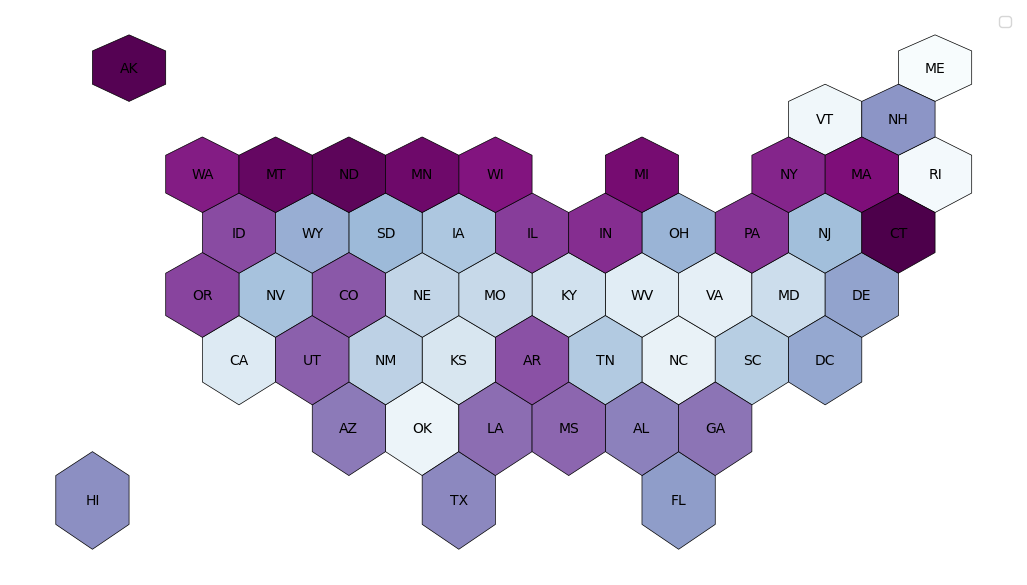

In [19]:
# Initialize the figure
fig, ax = plt.subplots(1, figsize=(13, 13))

# Draw a map with matplotlib
geoData.plot(
    ax=ax, 
    cmap="BuPu", 
    edgecolor='black', 
    linewidth=.5
)
# add a "centroid" column with the centroid position of each state
geoData['centroid'] = geoData['geometry'].apply(lambda x: x.centroid)

# for each state, annotate with the state name located at the centroid coordinates 
for idx, row in geoData.iterrows():
    ax.annotate(
        text=row['iso3166_2'], 
        xy=row['centroid'].coords[0], 
        horizontalalignment='center', 
        va='center',
        color="black"
    )
# Remove axis
ax.axis('off')

# Add a color bar
#sm = plt.cm.ScalarMappable(cmap='BuPu', ax=1)
#fig.colorbar(sm, orientation="horizontal", aspect=50, fraction=0.005, pad=0 )

In [33]:
state_ed_lvl =combined_df[['state','ed_lvl']].groupby('state').value_counts().reset_index()
#state_ed_lvl=state_ed_lvl.sort_values(by='math_conf_lvl',ascending= False)
state_ed_lvl

,state,ed_lvl,count
0,Alabama,some college,131
1,Alabama,HS Grad,98
2,Alabama,Bachelors,85
3,Alabama,Associates,52
4,Alabama,GED,51
...,...,...,...
352,Wyoming,HS Grad,75
353,Wyoming,Associates,71
354,Wyoming,Post Grad,57
355,Wyoming,GED,25


In [36]:
ed_lvl_pivot =state_ed_lvl.pivot(index='state', 
                    columns = 'ed_lvl', 
                    values = 'count')
ed_lvl_pivot

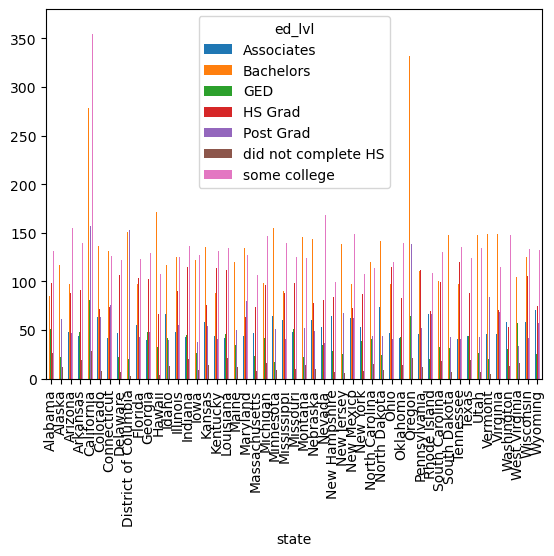

In [42]:
ed_lvl_pivot.plot(kind='bar')
plt.rcParams["figure.autolayout"] = True


In [50]:
ed_lvl_pivot.describe().T

,count,mean,std,min,25%,50%,75%,max
ed_lvl,,,,,,,,
Associates,51.0,56.549020,19.348709,16.0,45.5,53.0,63.5,146.0
Bachelors,51.0,129.117647,42.222576,85.0,101.0,122.0,143.5,332.0
GED,51.0,35.450980,13.666475,15.0,25.0,33.0,44.5,81.0
HS Grad,51.0,90.607843,24.088236,53.0,74.0,88.0,101.0,196.0
Post Grad,51.0,57.666667,26.653080,34.0,41.5,50.0,67.0,157.0
did not complete HS,51.0,13.254902,5.945900,3.0,9.0,13.0,17.0,29.0
some college,51.0,135.392157,47.917044,81.0,120.0,127.0,136.0,362.0


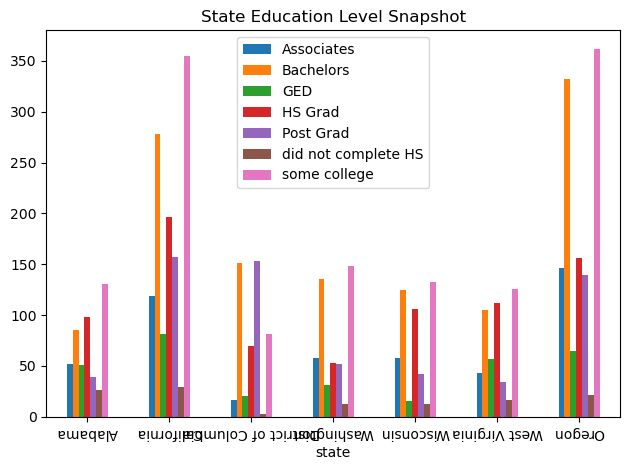

In [73]:
max_min_states = ed_lvl_pivot.loc[['Alabama', 'California', 'District of Columbia', 'Washington', 
                            'Wisconsin', 'West Virginia', 'Oregon']]

# Creating Plot
max_min_states.plot(kind='bar')

#Adding Details
plt.title('State Education Level Snapshot')
plt.legend(loc='upper center')